# Transición entre ocupaciones

Con datos de panel de la Encuesta Contínua de Empleo, es posible comprender mejor las trayectorias de movimiento ocupacional en la población boliviana y sus retornos. En este trabajo identifico eventos donde una misma persona reporta el cambio de su ocupación principal entre dos periodos de tiempo. Agregando esta información es posible construir mapas de las opciones laborales más probables y disponibles a sujetos en una ocupación y con diferentes características demográficas, y discernir cómo estas diferentes opciones afectan positiva o negativamente sus ingresos. ¿Qué trayectorias ocupacionales específicas dirigen mejoras en la calidad de vida de la población boliviana?

In [5]:
import pandas as pd
import pdfplumber
import json
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import ticker, dates, cm, colors
import numpy as np
import re
from collections import ChainMap
from textwrap import wrap
import networkx as nx
import unicodedata
from IPython import display
import math

pd.options.display.max_columns=500
pd.options.display.max_colwidth=500
pd.options.display.max_rows=100
plt.style.use('publish/estilo.mplstyle')

In [2]:
def get_caeb(pdf_filename):
    """
    Construye un diccionario de los códigos y nombres en 
    la Clasificación de Actividades Económicas de Bolivia.
    """
    
    pdf = pdfplumber.open(pdf_filename)
    caeb = {}
    for i, page in enumerate(pdf.pages[28:62]):
        rows = page.extract_text().split('\n')
        rows = rows[[i + 1 for i, row in enumerate(rows) if 'DESCRIPCIÓN' in row][0]:-1]
        for row in rows:
            categoria = re.findall('^[A-Z]\s\s\s\s+', row)
            if len(categoria) > 0:
                cat = categoria[0].strip()
                caeb[cat] = []
            actividad = re.findall('[0-9]+', row)
            if len(actividad) > 0:
                caeb[cat].append(actividad[0])

    actividades = [{actividad:key for actividad in caeb[key]} for key in caeb.keys()]
    actividades = dict(ChainMap(*actividades))
    caeb = {**actividades, **{key:key for key in caeb.keys()}}

    return caeb

def get_cob(pdf_filename):
    """
    Construye un diccionario de los códigos y nombres en 
    la Clasificación de Ocupaciones de Bolivia 2009.
    """
    
    pdf = pdfplumber.open(pdf_filename)
    cob = {}
    for i, page in enumerate(pdf.pages[29:43]):

        p = unicodedata.normalize(u'NFKD', page.extract_text()).encode('ascii', 'ignore').decode('utf8')
        rows = re.split('\n(?=[\s0-9])', p)
        rows = rows[[i + 1 for i, row in enumerate(rows) if 'DESCRIPCION' in row][0]:-1]

        for row in rows:
            codigo = re.findall('[0-9]+', row)[0]
            nombre = re.findall('[A-Za-z][A-Za-z\s\/\;\,\.]+', row)[0].split('\n')[0].lower()
            cob[codigo] = nombre

    return cob

def flatten_cob(cob, level=2):
    """
    Aplana entradas en el diccionario de ocupaciones a
    un nivel específico para facilitar operaciones agregadas
    """
    
    cob2 = {}
    categories = [c for c in cob.keys() if len(c) == level]
    i = -1
    
    for c in cob.keys():
        
        nivel = len(c)
        
        if nivel == level:
            i += 1
            cob2[c] = cob[categories[i]]
        elif nivel > level and c[:level] == categories[i]:
            cob2[c] = cob[categories[i]]
        elif nivel < level:
            cob2[c] = cob[categories[i + 1]]
            
    return cob2

def diccionarios(ocupaciones_nivel):
    """
    Retorna los diccionarios necesarios para intepretar
    valores en la encuesta.
    """
    
    actividades = {
        'A': 'agricultura, ganadería, caza , pesca y silvicultura',
        'B': 'explotación de minas y canteras',
        'C': 'industria manufacturera',
        'D': 'suministro de electricidad, gas, vapor y aire acondicionado',
        'E': 'suministro de agua; evacuación de aguas residuales, gestión de desechos y descontaminación',
        'F': 'construcción',
        'G': 'venta por mayor y por menor; reparación de vehículos automotores y motocicletas',
        'H': 'transporte y almacenamiento',
        'I': 'actividades de alojamiento y servicio de comidas',
        'J': 'información y comunicaciones',
        'K': 'intermediación financiera y seguros',
        'L': 'actividades inmobiliarias',
        'M': 'servicios profesionales y técnicos',
        'N': 'actividades de servicios administrativos y de apoyo',
        'O': 'administración pública, defensa y planes de seguridad social de afiliación obligatoria',
        'P': 'servicios de educación',
        'Q': 'servicios de salud y de asistencia social',
        'R': 'actividades artísticas, de entretenimiento y recreativas',
        'S': 'otras actividades de servicios',
        'T': 'actividades de hogares privados como empleadores',
        'U': 'servicios de organizaciones y órganos extraterritoriales'
    }

    niveles_educativos = {
        10: 'ninguno y no sabe leer y escribir',
        11: 'ninguno pero sabe leer y escribir',
        12: 'programa de alfabetización',
        13: 'educación inicial o pre-escolar (pre kinder/kinder)',
        21: 'sistema escolar antiguo - básico (1 a 5 años)',
        22: 'sistema escolar antiguo - intermedio (1 a 3 años)',
        23: 'sistema escolar antiguo - medio (1 a 4 años)',
        31: 'sistema escolar anterior - primaria (1 a 8 años)',
        32: 'sistema escolar anterior - secundaria (1 a 4 años)',
        41: 'sistema escolar actual - primaria (1 a 6 años)',
        42: 'sistema escolar actual - secundaria (1 a 6 años)',
        51: 'educación de adultos (sistema antiguo) - educación básica de adultos (eba)',
        52: 'educación de adultos (sistema antiguo) - centro de educación media de adultos (cema)',
        61: 'educación alternativa y especial - educación juvenil alternativa (eja)',
        62: 'educación alternativa y especial - educación primaria para adultos (epa)',
        63: 'educación alternativa y especial - educación secundaria para adultos (esa)',
        64: 'educación alternativa y especial - programa nacional de post alfabetización',
        65: 'educación alternativa y especial - educación especial',
        71: 'educación superior - normal (escuela sup. de formación de maestros)',
        72: 'educación superior - universidad pública (licenciatura)',
        73: 'educación superior - universidad privada (licenciatura)',
        74: 'educación superior - postgrado diplomado',
        75: 'educación superior - postgrado maestría',
        76: 'educación superior - postgrado doctorado',
        77: 'educación superior - técnico de universidad',
        78: 'técnico de instituto (duración mayor o igual a 1 año)',
        79: 'institutos de formación militar y policial',
        80: 'educación técnica de adultos (eta)',
        81: 'otros cursos (duración menor a 1 año)'
    }

    deptos = {
        1: 'Chuquisaca',
        2: 'La Paz',
        3: 'Cochabamba',
        4: 'Oruro',
        5: 'Potosí',
        6: 'Tarija',
        7: 'Santa Cruz',
        8: 'Beni',
        9: 'Pando'
    }
    
    caeb = get_caeb('data/CAEB_2011.pdf')
    municipios = pd.read_csv('data/municipios.csv', index_col='cod_ine').municipio
    cob = get_cob('data/COB_2009.pdf')
    ocupaciones = flatten_cob(cob, ocupaciones_nivel)
    
    return caeb, actividades, niveles_educativos, deptos, municipios, ocupaciones, cob

def format_data(dfi, caeb, actividades, niveles_educativos, deptos, municipios, ocupaciones):
    """
    Formatea datos de la encuesta con los diccionarios y 
    las funciones disponibles.
    """
    
    def dateformat_nacimiento(x):
        if x[0] != ' ':
            try:
                return dt.datetime.strptime('{}-{}-{}'.format(x[0], x[1], x[2]), '%Y-%m-%d')
            except Exception as e:
                return None
        else:
            return None
    
    def parse_año(dfi):
        dfi['año'] = dfi['año'].astype(int)
        return dfi
    
    def parse_trimestre(dfi):
        dfi['trimestre'] = dfi['trimestre'].astype(int)
        return dfi
    
    def parse_dep(dfi):
        dfi['dep'] = dfi.dep.map(deptos)
        return dfi
    
    def parse_area(dfi):
        dfi['area'] = dfi['area'].map({1: 'urbana', 2: 'rural'})
        return dfi
    
    def parse_sexo(dfi):
        dfi['sexo'] = dfi['sexo'].map({1: 'hombre', 2: 'mujer'})
        return dfi
    
    def parse_nacimiento(dfi):
        i = dfi.columns.tolist().index('nacimiento_año')
        dfi.insert(i, 'nacimiento', dfi[['nacimiento_año', 'nacimiento_mes', 'nacimiento_dia']].apply(lambda x: dateformat_nacimiento(x), axis=1))
        dfi.drop(columns=['nacimiento_año', 'nacimiento_mes', 'nacimiento_dia'], inplace=True)
        return dfi
    
    def parse_educacion(dfi):
        dfi['educacion'] = dfi.educacion.apply(lambda x: int(x) if x != ' ' else None).map(niveles_educativos)
        return dfi
    
    def parse_años_estudio(dfi):
        dfi['años_estudio'] = pd.to_numeric(dfi.años_estudio, errors='coerce')
        return dfi
    
    def parse_nivel_educativo(dfi):
        dfi['nivel_educativo'] = pd.to_numeric(dfi.nivel_educativo, errors='coerce').map({0: 'ninguno', 1.0: 'primaria incompleta', 2.0: 'primaria completa', 3.0:'secundaria incompleta', 4.0:'secundaria completa', 5.0:'superior', 7.0:'otro'})
        return dfi
    
    def parse_trabaja_semana(dfi):
        dfi['trabaja_semana'] = dfi.trabaja_semana.map({'1': 'si', '2': 'no'})
        return dfi
    
    def parse_trabaja(dfi):
        dfi['trabaja'] = dfi.trabaja.map({'1': 'si', '2': 'no'})
        return dfi
    
    def parse_municipio(dfi):
        dfi['municipio'] = pd.to_numeric(dfi.municipio, errors='coerce')
        return dfi
    
    def parse_actividad(dfi):
        dfi['actividad'] = dfi['actividad'].map(caeb).map(actividades)
        return dfi
    
    def parse_ocupacion(dfi):
        dfi['ocupacion'] = dfi['ocupacion'].map(ocupaciones)
        return dfi
    
    def parse_horas_semana(dfi):
        dfi['horas_semana'] = pd.to_numeric(dfi.horas_semana, errors='coerce')
        return dfi
    
    def parse_tiempo(dfi):
        dfi['tiempo_unidad'] = pd.to_numeric(dfi.tiempo_unidad, errors='coerce').map({2: 1/53, 4: 1/12, 8: 1})
        dfi['tiempo'] = pd.to_numeric(dfi.tiempo, errors='coerce') * dfi.tiempo_unidad
        dfi.drop(columns=['tiempo_unidad'], inplace=True)
        return dfi
    
    def parse_nit(dfi):
        dfi['nit'] = dfi.nit.map({'1': 'regimen general', '2': 'regimen simplificado', '3': 'no tiene'})
        return dfi
    
    def parse_tamaño_empresa(dfi):
        dfi['tamaño_empresa'] = pd.to_numeric(dfi.tamaño_empresa, errors='coerce')
        return dfi
    
    def parse_salario(dfi):
        dfi['salario'] = pd.to_numeric(dfi.salario, errors='coerce')
        dfi['salario_frecuencia'] = pd.to_numeric(dfi.salario_frecuencia, errors='coerce').map({1.0: 1.0, 2.0: 1/7, 3.0: 1/15, 4.0: 1/30, 5.0: 1/60, 6.0:1/90, 7.0:1/180, 8.0:1/365})
        dfi['salario'] = dfi.salario * dfi.salario_frecuencia
        dfi.drop(columns=['salario_frecuencia'], inplace=True)
        return dfi
    
    def parse_ingreso(dfi):
        dfi['ingreso'] = pd.to_numeric(dfi.ingreso, errors='coerce')
        dfi['ingreso_frecuencia'] = pd.to_numeric(dfi.ingreso_frecuencia, errors='coerce').map({1.0: 1.0, 2.0: 1/7, 3.0: 1/15, 4.0: 1/30, 5.0: 1/60, 6.0:1/90, 7.0:1/180, 8.0:1/365})
        dfi['ingreso'] = dfi.ingreso * dfi.ingreso_frecuencia
        dfi.drop(columns=['ingreso_frecuencia'], inplace=True)
        return dfi
    
    def parse_trabaja_semana_2(dfi):
        dfi['trabaja_semana_2'] = dfi['trabaja_semana_2'].map({'1': 'si', '2': 'no'})
        return dfi
    
    def parse_trabaja_2(dfi):
        dfi['trabaja_2'] = dfi['trabaja_2'].map({'1': 'si', '2': 'no'})
        return dfi
    
    def parse_ocupacion_2(dfi):
        dfi['ocupacion_2'] = dfi['ocupacion_2'].map(ocupaciones)
        return dfi
    
    def parse_actividad_2(dfi):
        dfi['actividad_2'] = dfi['actividad_2'].map(caeb).map(actividades)
        return dfi
    
    parsers = {
        'año': parse_año,
        'trimestre': parse_trimestre,
        'dep': parse_dep,
        'area': parse_area,
        'sexo': parse_sexo,
        'nacimiento_año': parse_nacimiento,
        'educacion': parse_educacion,
        'años_estudio': parse_años_estudio,
        'nivel_educativo': parse_nivel_educativo,
        'trabaja_semana': parse_trabaja_semana,
        'trabaja': parse_trabaja,
        'municipio': parse_municipio,
        'actividad': parse_actividad,
        'ocupacion': parse_ocupacion,
        'horas_semana': parse_horas_semana,
        'tiempo': parse_tiempo,
        'nit': parse_nit,
        'tamaño_empresa': parse_tamaño_empresa,
        'salario': parse_salario,
        'ingreso': parse_ingreso,
        'trabaja_semana_2': parse_trabaja_semana_2,
        'trabaja_2': parse_trabaja_2,
        'ocupacion_2': parse_ocupacion_2,
        'actividad_2': parse_actividad_2
    }
   
    for col in parsers.keys():
        if col in dfi.columns:
            dfi = parsers[col](dfi)    
    
    return dfi
    
def load_data(column_filter):
    """
    Carga una serie de columnas de la encuesta, cambia sus nombres
    a nombres más fáciles de interpretar y devuelve una tabla
    con el orden de columnas provisto.
    """
    
    column_names = {
        'id_per_panel': 'id_panel',
        'panel': 'panel',
        'gestion': 'año',
        'trimestre': 'trimestre',
        'depto': 'dep',
        'area': 'area',
        's1_02': 'sexo',
        's1_03ba': 'nacimiento_dia',
        's1_03bb': 'nacimiento_mes',
        's1_03bc': 'nacimiento_año',
        's1_07a': 'educacion',
        'aestudio': 'años_estudio',
        'niv_ed': 'nivel_educativo',
        's2_01': 'trabaja_semana',
        's2_14': 'trabaja',
        's2_39deptocod': 'municipio',
        's2_16acod': 'actividad',
        's2_15acod': 'ocupacion',
        'phrs': 'horas_semana',
        's2_19a_t': 'tiempo',
        's2_19a_p': 'tiempo_unidad',
        's2_23': 'nit',
        's2_26': 'tamaño_empresa',
        's2_33_v': 'salario',
        's2_33_f': 'salario_frecuencia',
        's2_38_v': 'ingreso',
        's2_38_f': 'ingreso_frecuencia',
        's2_42': 'trabaja_semana_2',
        's2_43': 'trabaja_2',
        's2_44acod': 'ocupacion_2',
        's2_45acod': 'actividad_2'
    }
    
    dfi = pd.read_csv('data/encuesta_trabajo/ECE_4T15_1T21.csv', encoding='ISO-8859-1', delimiter=';', usecols=column_filter)[column_filter]
    dfi.columns = [column_names[col] for col in column_filter]
    return dfi

In [3]:
# Carga y formatea datos de la encuesta

column_filter = [
    'id_per_panel',
    'panel',
    "gestion",
    "trimestre",
    "depto",
    "area",
    "s1_02",
    "s1_03ba",
    "s1_03bb",
    "s1_03bc",
    "s1_07a",
    "aestudio",
    "niv_ed",
    "s2_01",
    "s2_14",
    "s2_39deptocod",
    "s2_16acod",
    "s2_15acod",
    "phrs",
    "s2_19a_t",
    "s2_19a_p",
    "s2_23",
    "s2_26",
    "s2_33_v",
    "s2_33_f",
    "s2_38_v",
    "s2_38_f",
    's2_42',
    's2_44acod',
    's2_45acod'
]

caeb, actividades, niveles_educativos, deptos, municipios, ocupaciones, cob = diccionarios(ocupaciones_nivel=5)
df = load_data(column_filter)
df = format_data(df, caeb, actividades, niveles_educativos, deptos, municipios, ocupaciones)

/home/m/.virtualenvs/data/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
def get_eventos(dfi):
    """
    Encuentra eventos donde una misma persona cambia de ocupación,
    y devuelve una tabla con todos sus atributos en el periodo de cambio 
    más datos de ingreso, ocupación y actividad del periodo de su anterior
    ocupación.
    """
    
    dfi = dfi.sort_values(['año', 'trimestre'])
    
    ocupacion_base = np.nan
    for i, row in dfi.iterrows():
        if type(ocupacion_base) != str:
            if type(row.ocupacion) == str:
                ocupacion_base = row.ocupacion
                ingreso_base = row.ingreso
                salario_base = row.salario
                actividad_base = row.actividad
        else:
            if type(row.ocupacion) == str:
                if row.ocupacion != ocupacion_base:

                    row_dict = row.to_dict()
                    row_dict['ocupacion_base'] = ocupacion_base 
                    row_dict['ingreso_base'] = ingreso_base
                    row_dict['salario_base'] = salario_base
                    row_dict['actividad_base'] = actividad_base
                    eventos.append(row_dict)

                    ocupacion_base = row.ocupacion

                ingreso_base = row.ingreso
                salario_base = row.salario
                actividad_base = row.actividad

# Encuentra eventos de cambio de ocupación entre individuos que participan de la encuesta de panel
no_panel = df.id_panel.value_counts()[df.id_panel.value_counts() == 1].index
eventos = []
for id_panel, dfi in df[(df.ocupacion.notna()) & ~(df.id_panel.isin(no_panel))].groupby('id_panel'):
    get_eventos(dfi)

# Construye una tabla con todos los eventos, crea columnas de ganancia en el periodo anterior y actual al cambio, donde incluye 
# valores disponibles de ingreso o salario, crea una columna `ganancia_delta` que representa la ganancia del periodo actual al cambio 
# como porcentaje de la ganancia en el periodo anterior, para identificar la dirección de saltos en movilidad ocupacional. Además 
# agrega columnas de edad para permitir algunos tipos de análisis.
edf = pd.DataFrame(eventos)
edf['ganancia_base'] = edf[['ingreso_base', 'salario_base']].apply(lambda row: row[0] if not math.isnan(row[0]) else row[1], axis=1)
edf['ganancia'] = edf[['ingreso', 'salario']].apply(lambda row: row[0] if not math.isnan(row[0]) else row[1], axis=1)
edf = edf[(edf.ganancia.notna()) & (edf.ganancia_base.notna())]
edf['ganancia_delta'] = edf['ganancia'] / edf['ganancia_base']
edf['edad'] = 2020 - edf.nacimiento.dt.year
edf['edad_range'] = pd.cut(edf.edad, bins=range(0,120,5), labels=range(0,115,5))

In [25]:
display.display(display.Markdown('Entre 2015 y el primer trimestre de 2021, identifico {} eventos. Un ejemplo de evento:'.format(len(edf))))
display.display(edf.sample()[['año', 'trimestre', 'dep', 'sexo', 'ocupacion_base', 'ocupacion', 'ganancia_base', 'ganancia', 'ganancia_delta']].T)

Entre 2015 y el primer trimestre de 2021, identifico 71795 eventos. Un ejemplo de evento:

,19453
año,2017
trimestre,1
dep,Tarija
sexo,mujer
ocupacion_base,trabajadoras del hogar
ocupacion,vendedores en puestos fijos y moviles
ganancia_base,56.6667
ganancia,50
ganancia_delta,0.882353


In [7]:
def get_movilidad(edfi, min_sample=5):
    """
    Agrega saltos entre cada par de ocupaciones, y retorna una tabla
    con la ocupación en el periodo anterior, la ocupación a la cual 
    se traslada, el número de eventos con este salto particular y 
    el cambio promedio sobre la ganancia. Adicionalmente es posible 
    retornar sólo saltos con un número mínimo de eventos.
    """
    
    dfi = edfi.groupby(['ocupacion_base', 'ocupacion'])
    movilidad = pd.concat([dfi.size(), dfi.ganancia_delta.mean()], axis=1)
    movilidad.columns = ['muestra', 'delta']
    movilidad = movilidad.reset_index()
    movilidad = movilidad[movilidad.muestra >= min_sample]
    return movilidad

def reverse_cob(to_level=1):
    """
    Retorna un diccionario para asociar cada valor de COB a valores
    en un nivel de la nomenclatura. Es útil para agregar ocupaciones
    en menos categorías.
    """
    cob_rev = {cob[k]:k for k in cob.keys()}
    cob_1 = flatten_cob(cob, to_level)
    return pd.Series(cob_rev).map(cob_1).to_dict()

mov = get_movilidad(edf, 1)
ocupaciones_reverse = reverse_cob()

In [36]:
display.display(display.Markdown('Estos eventos describen {} posibles transiciones entre pares de ocupaciones, que generan en promedio una ganancia correspondiente a {:.1%} de la ganancia en la anterior ocupación. Es fácil perderse en exploraciones sobre el universo de opciones laborales para diferentes tipos de personas. Por ejemplo, siguiendo el anterior ejemplo ¿cuáles son las transiciones más probables y rentables desde la ocupación de trabajadora del hogar?:'.format(len(mov), mov.delta.mean())))
display.display(mov[(mov.ocupacion_base == 'trabajadoras del hogar') & (mov.muestra >= 20)].set_index('ocupacion')[['muestra', 'delta']].sort_values('delta', ascending=False).rename(columns={'muestra': 'Número de eventos', 'delta': 'Ganancia actual como % de la ganancia en la anterior ocupación'}))

Estos eventos describen 15116 posibles transiciones entre pares de ocupaciones, que generan en promedio una ganancia correspondiente a 156.7% de la ganancia en la anterior ocupación. Es fácil perderse en exploraciones sobre el universo de opciones laborales para diferentes tipos de personas. Por ejemplo, siguiendo el anterior ejemplo ¿cuáles son las transiciones más probables y rentables desde la ocupación de trabajadora del hogar?:

,Número de eventos,Ganancia actual como % de la ganancia en la anterior ocupación
ocupacion,,
"sastres, modistos y otros confeccionistas de prendas de vestir",21,2.212880
vendedores en puestos fijos y moviles,47,2.082505
trabajadores de la elaboracion de productos de panaderia y pasteleria,34,1.615607
cocineros,222,1.601625
vendedores en tiendas y almacenes,58,1.417512
"limpiadores de viviendas, oficinas, hoteles y otras edificaciones",421,1.281291
lavanderas y planchadoras manuales,76,1.242106
cuidadores de ninos y auxiliares de maestros,104,1.100297
ayudantes de cocina,33,1.075486


Sin embargo, para tomar una vista más completa del universo de transiciones ocupacionales construyo una red donde cada nodo es una ocupación y cada enlace una transición de una a otra ocupación que ocurre al menos 10 veces. Enlaces grises representan transiciones que mejoran ingresos en promedio y enlaces azules transiciones que los empeoran. Estos colores también se aplican a los bordes de cada nodo, donde nodos para ocupaciones que en promedio mejoran o empeoran ingresos son grises y azules respectivamente. El grosor de cada borde refleja cuán intensos son estos cambios. El tamaño de los nodos representa el número de eventos donde individuos adoptan cada ocupación. Finalmente, el color representa la clasificación de cada ocupación en el nivel más general de la Clasificación de Ocupaciones de Bolivia.

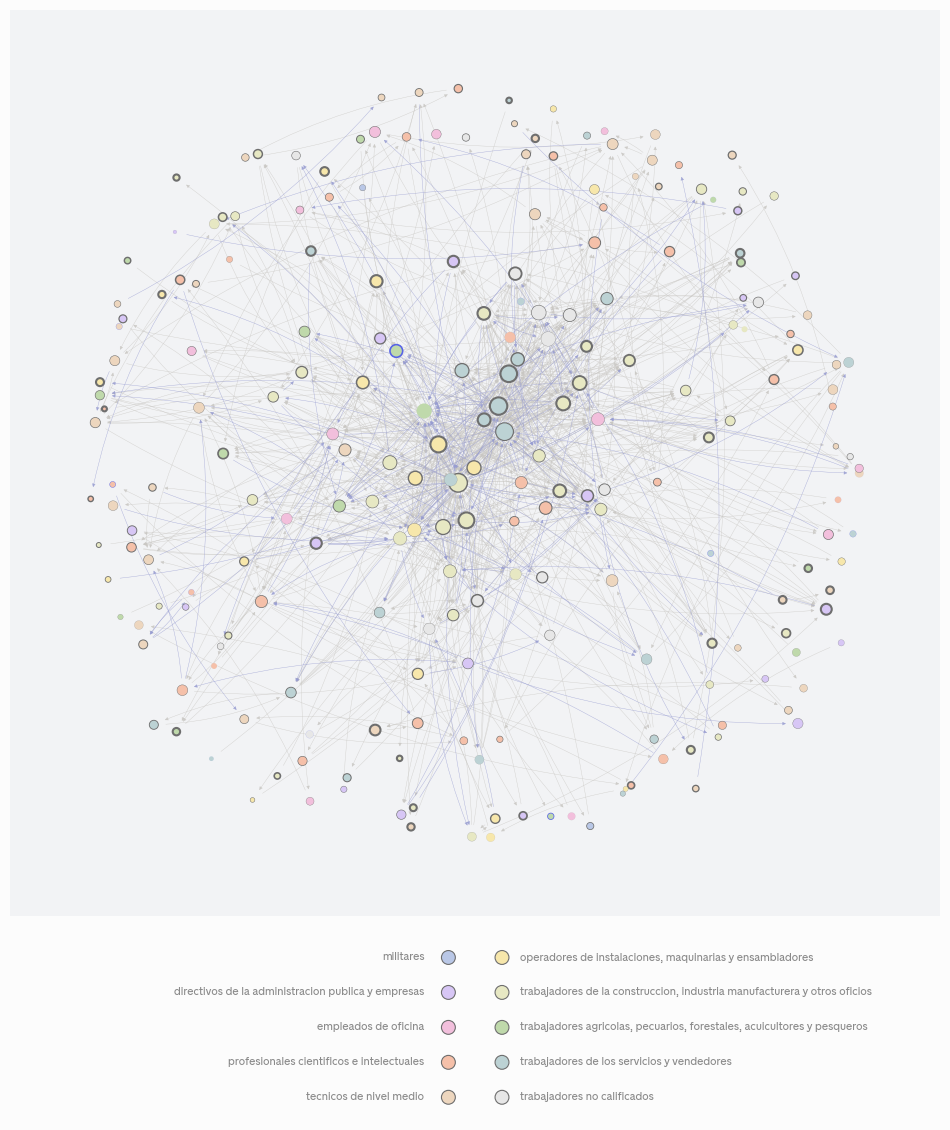

<p class="caption"> <em>Transición entre ocupaciones en Bolivia (<a href="https://github.com/mauforonda/notas/raw/main/plots/transicion_ocupaciones.png">imagen en alta resolución</a>) </em> </p>

In [8]:
def plot_graph(mov, ocupaciones_reverse):
    """
    Dibuja una red donde cada nodo es una ocupación y cada enlace un salto entre dos ocupaciones. 
    Si el efecto del salto es positivo sobre la ganancia en promedio, el enlace es gris, y si es 
    negativo el enlace es azul. Si saltos a una ocupación son en promedio positivos, el contorno
    del nodo es gris, y si saltos son en promedio negativos el contorno es azul. El grueso del 
    contorno de cada nodo refleja cuán negativos o positivos son en promedio saltos a cada 
    ocupación. El tamaño de un nodo representa el número de eventos donde individuos saltan
    a cada ocupación. El color de los nodos corresponde a la posición de la ocupación en el 
    nivel más alto de la clasificación COB.
    """
    
    def delta_scale(mov):
        delta_size = mov.groupby('ocupacion').delta.mean()
        delta_size = pd.concat([1 - (1 / delta_size[delta_size < 1]), (delta_size[delta_size >= 1] - 1)])
        delta_size.loc[delta_size < -1] = -1
        delta_size.loc[delta_size > 1] = 1
        return delta_size.to_dict()
    
    def node_scale(mov):
        muestras_destino = mov.groupby('ocupacion').muestra.sum()
        return (np.log(muestras_destino) ** 2.4).to_dict()
    
    ocupaciones_colores = {
        'militares': '#b9c7e6',
        'directivos de la administracion publica y empresas': '#d7c6f5',
        'empleados de oficina': '#f2bfdc',
        'profesionales cientificos e intelectuales': '#f5c0a9',
        'tecnicos de nivel medio': '#edd6be',
        'operadores de instalaciones, maquinarias y ensambladores': '#f7e7ab',
        'trabajadores de la construccion, industria manufacturera y otros oficios':'#e7e8c3',
        'trabajadores agricolas, pecuarios, forestales, acuicultores y pesqueros': '#bfd9ab',
        'trabajadores de los servicios y vendedores': '#bcd2d4',
        'trabajadores no calificados':'#e7e7e7'
    }
    linecolor = '#6e6e6e'
    background = '#fcfcfc'
    edgeline_colors = {True: '#c9c7c3', False: '#979cd1'}
    nodeline_colors = {True: linecolor, False: '#5763e6'}
    
    colormap = colors.ListedColormap(cm.get_cmap('PRGn')(np.linspace(.2,.8, 255)))
    delta_size = delta_scale(mov)
    muestras_destino = node_scale(mov)

    f, ax = plt.subplots(1,1,figsize=(12,12), dpi=100)
    f.set_facecolor(background)

    g2 = nx.from_pandas_edgelist(mov[(mov.muestra >= 10)].rename(columns={'muestra': 'weight'}), 'ocupacion_base', 'ocupacion', ['weight', 'delta'], create_using=nx.DiGraph())
    pos = nx.spring_layout(g2, k=1.3, iterations=30)
    
    nodes = g2.nodes()
    node_size = [muestras_destino[n] for n in nodes]
    node_color = [ocupaciones_colores[ocupaciones_reverse[n]] for n in nodes]
    nodeline_color = [nodeline_colors[ delta_size[n] > 0 ] for n in nodes]
    nodeline_width = [abs(delta_size[n]) * 1.5 for n in nodes]
    nx.draw_networkx_nodes(g2, pos, nodelist=nodes, node_size=node_size, node_color=node_color, ax=ax, edgecolors=nodeline_color, linewidths=nodeline_width)
    
    edges_positive = [(u ,v) for u,v,e in g2.edges(data=True) if e['delta'] >= 1]
    edges_negative = [(u ,v) for u,v,e in g2.edges(data=True) if e['delta'] < 1]
    
    for edges, direction in zip([edges_positive, edges_negative], [True, False]):
        
        pos_i = {**{u:pos[u] for (u,v) in edges}, **{v:pos[v] for (u,v) in edges}}
        nx.draw_networkx_edges(g2, pos_i, edgelist=edges, alpha=.8, width=.3, ax=ax, edge_color=edgeline_colors[direction], arrowsize=5, connectionstyle="arc3,rad=0.1")

    for ocupaciones_group, esquina, x, ha, xlim  in zip([list(ocupaciones_colores.keys())[:5], list(ocupaciones_colores.keys())[5:]], [.457, .46], [.4, 1.6], ['right', 'left'], [(0,3), (-2,2)]):
        
        cax = f.add_axes([esquina, -.045, .1, .15])
        cax.scatter(x=len(ocupaciones_group) * [1], y=range(5),  color=[ocupaciones_colores[oc] for oc in ocupaciones_group], s=100, linewidth=.8, edgecolor=linecolor)
        cax.set_xlim(xlim)
        cax.set_ylim(4.65,-.5)
        for oc, position in zip(ocupaciones_group, range(5)):
            cax.annotate('\n'.join(wrap(oc, 100)), xy=(x, position), xycoords='data', ha=ha, va='center', fontsize=8, color=linecolor, alpha=.8)
        cax.set_axis_off()
        
    filename = 'plots/transicion_ocupaciones.png'
    f.savefig(filename, bbox_inches='tight', pad_inches=.4, dpi=200)
    plt.show()
    display.display(display.Markdown('<p class="caption"> <em>Transición entre ocupaciones en Bolivia (<a href="https://github.com/mauforonda/notas/raw/main/{}">imagen en alta resolución</a>) </em> </p>'.format(filename)))

plot_graph(mov, ocupaciones_reverse)

Existen más cosas que ver y aprender de este gráfico de las que puedo escribir en este momento. Un par de primeras observaciones serían que muchas ocupaciones agrícolas son frecuentes, pero tienden a reducir el ingreso de la población. El intercambio entre estas ocupaciones y aquellas de construcción, operación de maquinaria y comercio es intenso y se da en ambas direcciones. Sin embargo, sólo parece producir mejoras claras de ingresos cuando representa escapes de ocupaciones agrícolas. Transiciones fuera de ocupaciones agrícolas generan los cambios más positivos y frecuentes en la red. Esta observación podría reflejar movimientos temporales de ocupación, donde individuos trabajan en la tierra por unos meses y se dedican a la construcción y comercio en otros, guiados por la temporalidad y riesgo en la actividad agrícola. Es claro que transiciones fuera de ocupaciones agrícolas y hacia sectores como el comercio, que florecen en la informalidad e indiferencia estatal, se encuentran entre las intervenciones de desarrollo más importantes de la última media década.